# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 17 de abril de 2022__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [1]:
RANDOM_STATE = 10

# Apartado 2: Recuperación de información

__Número de grupo: 5__

__Nombres de los estudiantes: Jorge Villacorta y Pablo Martinez__

## 1) Carga del conjunto de datos

El fichero `BBC News.csv` contiene noticias clasificadas en 5 categorías diferentes. 

Carga los datos en un dataframe teniendo en cuenta que la columna `ArticleId` es un identificador de la noticia y por lo tanto no lo vamos a usar. 

Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías.

Crea una partición estratificada de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('BBC News.csv')
df = pd.DataFrame(df, columns= ['Text','Category'])

df

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business
...,...,...
1485,double eviction from big brother model caprice...,entertainment
1486,dj double act revamp chart show dj duo jk and ...,entertainment
1487,weak dollar hits reuters revenues at media gro...,business
1488,apple ipod family expands market apple has exp...,tech


In [27]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=10)

aux= {'Text' : train_data.Text.tolist(),
     'Category' : train_data.Category.tolist()}

train_data = pd.DataFrame(aux, columns = ['Text', 'Category'])

aux= {'Text' : test_data.Text.tolist(),
     'Category' : test_data.Category.tolist()}

test_data = pd.DataFrame(aux, columns = ['Text', 'Category'])

print(len(train_data))
print(len(test_data))

1192
298


Hasta aqui, realizamos los mismo pasos que hemos realizado en la parte 1, con lo cual no hay nada destacable que comentar en esta seccion de la practica.

## 2) Representación basada en bolsa de palabras y tf-idf

La primera vectorización que vamos a usar representará los mensajes usando el modelo de bolsa de palabras, monogramas y el valor tf-idf de cada palabra. Usa como _stop words_ las que vienen configuradas por defecto para el inglés.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test. Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

Calcula la precisión@5 de cada una de las clases usando como consultas los documentos de la partición de test y la similitud del coseno. Vamos a considerar que un documento recuperado es relevante cuando pertenezca a la misma clase que la consulta.

Dibuja los resultados en un diagrama de barras y comenta las clases en las que se comporta mejor y peor. ¿Crees que los resultados son buenos?

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
# Utilizamos como stop_words las que vienen configuradas por defecto para el inglés
vectorizer = CountVectorizer(stop_words='english', binary=False,ngram_range=(1,1))

train_vector_data=vectorizer.fit_transform(train_data.Text)
test_vector_data = vectorizer.fit_transform(test_data.Text)

feature_names = vectorizer.get_feature_names ()
print(len(feature_names))

11481


In [47]:
print(feature_names[:30])
print(feature_names[600:630])
print(feature_names[-30:])

['000', '000m', '000th', '0130', '028', '033', '04', '0400', '04secs', '05', '05m', '06', '070', '0800', '0845', '10', '100', '100bn', '100m', '101', '102', '1080', '109', '109m', '10bn', '10m', '10th', '11', '110m', '111']
['advanced', 'advancing', 'advantage', 'adventure', 'adversely', 'adversity', 'advertisements', 'advertising', 'adverts', 'advice', 'advise', 'advised', 'adviser', 'advising', 'advisory', 'advocate', 'aero', 'aeronautics', 'aeroplane', 'aerosmith', 'aerospace', 'aesthetic', 'aesthetically', 'aesthetics', 'affable', 'affair', 'affairs', 'affect', 'affected', 'affectionately']
['youzhny', 'yuan', 'yugansk', 'yuganskneftegaz', 'yugoslavian', 'yukos', 'yusuf', 'zach', 'zajec', 'zar', 'zara', 'zealand', 'zealander', 'zealous', 'zed', 'zeeuw', 'zenden', 'zenith', 'zero', 'zeta', 'zhang', 'ziers', 'ziyi', 'zoellick', 'zone', 'zooms', 'zooropa', 'zuluaga', 'zurich', 'zvonareva']


Podemos observar que hay bastante terminos alfanumericos que no tienen mucho sentido, con lo cual vamos a solucionar esto haciendo uso del parametro token_pattern de CountVectorizer para eliminar estos terminos aparentemente irrelevantes.

In [48]:
vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range=(1,1), token_pattern=r'(?u)\b[A-Za-z]+\b') 

train_vector_data=vectorizer.fit_transform(train_data.Text)

feature_names = vectorizer.get_feature_names ()
print(len(feature_names))


21075


Podemos observar que se han eliminado 105 entradas, con lo cual al final no habia tanto "ruido" en el diccionario, apenas un 0.4% del conjunto total de terminos, pero sigue siendo bueno poder quitar ese ruido existente

Ahora procederemos a printear algunos mensajes, y ver que palabras se han eliminado en su forma vectorizada, para asi poder determinar que peso se le da a los distintos terminos que tenemos en el diccionario.

In [49]:
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index],'\n')
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [50]:
from sklearn.feature_extraction.text import TfidfTransformer 

tfidftrans = TfidfTransformer()
train_preprocessed = tfidftrans.fit_transform(train_vector_data)

In [51]:

write_terms(feature_names, train_data.Text, train_preprocessed,100)

Mensaje 100 : more power to the people says hp the digital revolution is focused on letting people tell and share their own stories  according to carly fiorina  chief of technology giant hewlett packard.  the job of firms such as hp now  she said in a speech at the consumer electronics show (ces)  was to ensure digital and physical worlds fully converged. she said the goal for 2005 was to make people the centre of technology. ces showcases 50 000 new gadgets that will be hitting the shelves in 2005. the tech-fest  the largest of its kind in the world  runs from 6 to 9 january.  the digital revolution is about the democratisation of technology and the experiences it makes possible   she told delegates.  revolution has always been about giving power to the people.  she added:  the real story of the digital revolution is not just new products  but the millions of experiences made possible and stories that millions can tell.  part of giving people more control has been about the freeing up

Podemos observar en el texto vectorizado que se han eliminado números, "stop-words", pero podemos observar que practicamente todas las palabras que aparecen en el texto, tambien aparecen en la bolsa de palabras.

In [37]:
from sklearn.metrics.pairwise import cosine_similarity

def knn(query, X_train, k):
    '''Devuelve los índices de los k documentos de entrenamiento más similares a la consulta usando 
    la similitud del coseno.
    
    Parámetros:
    - query: documento consulta vectorizado
    - X_train: documentos de entrenamiento vectorizados
    - k: número de documentos a recuperar
    
    Devuelve:
    - índices de los k documentos más similares a la consulta.
    '''
    
    # Necesitamos un vector de dimensión (1, X). Si se pasa un vector de dimensión X, transformarlo
    if len(query.shape) == 1:
        query = query.reshape(1, -1)

    simil = cosine_similarity(query, X_train)
    simil_idx = np.argsort(simil.flatten())
    simil_idx = simil_idx[::-1]
    return simil_idx[:k]

In [38]:
def precision_at_k(y_selected, y_real, k):
    '''Devuelve la precisión @k de los documentos seleccionados.
    
    Parametros:
    - y_selected: etiquetas de los documentos seleccionados (se usan los k primeros)
    - y_real: etiqueta de la categoría correcta
    - k: número de documentos que se tienen en cuenta
    
    Devuelve:
    - Precisión@k
    '''
    
    return np.sum(y_selected[:k] == y_real) / k * 100

In [39]:
def mean_precisions_per_class(X_train, y_train, X_test, y_test, k):
    '''Devuelve las precision@k media para cada una de las classes.
    
    Parámetros:
    - X_train: documentos de entrenamiento vectorizados.
    - y_train: etiquetas de los documentos de entrenamiento.
    - X_test: documentos vectorizados que se usan como consultas
    - y_test: etiquetas de los documentos que se usan como consultas
    - k: número de documentos considerados a recuperar por la consulta
    
    Devuelve:
    - Diccionario clase -> precisión en tanto por ciento.
    '''
    
    # diccionario categoría -> lista de precisiones
    y_precisions = {y: [] for y in np.unique(y_test)}
    
    # Calcular precision@k para cada consulta
    for x_query, y_query in zip(X_test, y_test):
        idx = knn(x_query, X_train, k)
        y_selected = np.take(y_train, idx)
        precision = precision_at_k(y_selected, y_query, k)
        y_precisions[y_query].append(precision)
        
    # Calcular medias
    for y in y_precisions:
        y_precisions[y] = np.mean(y_precisions[y])
    
    return y_precisions

In [52]:
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data = vectorizer.transform(test_data.Text)

# Si sobre la consulta también realizamos la ponderación TF/IDF estamos amplificando
# el efecto de la misma a la hora de recuperar ejemplos relevantes
test_preprocessed = tfidftrans.transform(test_vector_data)

In [78]:
p5 = mean_precisions_per_class(train_preprocessed, train_data.Category, test_preprocessed[:200], test_data.Category[:200], 5)
    
print(p5)

{'business': 75.42857142857143, 'entertainment': 80.45454545454545, 'politics': 88.0, 'sport': 97.6470588235294, 'tech': 96.0}


Podemos observar que se obtiene la mejor precisión@5 para los documentos de categoria deportes, lo que nos puede indicar que la categoria deportes tiene un vocabulario mas concreto que nos puede ayudar a clasificar mas facilmente los documentos de este tipo. La peor precisión seria para la categoría negocios, lo cual nos indica que va a ser mas dificil recuperar documentos de este tipo respecto a las demas categorias.

<AxesSubplot:xlabel='target'>

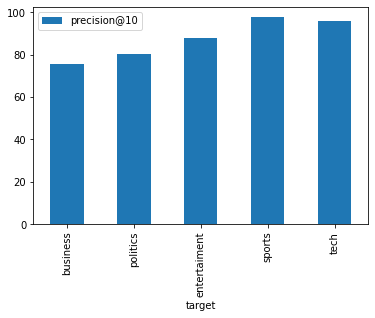

In [18]:
df_p5 = pd.DataFrame.from_dict(p5, orient='index', columns=['precision@10'])

df_p5["target"] =  ["business", "politics", "entertaiment", "sports", "tech"]

d = df_p5.set_index("target")

d.plot.bar()


Podemos observar que las precisiones se encuentran entre el 75% y el 95%, siendo la peor para  negocios y la mejor para deportes, conlo ual podemos decir que, en general, se recuperan los textos de manera bastante correcta. La categoria de deportes tiene un vocabulario mas concreto que el resto de categorias. Por ejemplo, la categoria entretenimiento puede tener terminos mas distantes entre si, mientras que el deporte tiene palabras mas cercanas entre si, "ball, "league", "player", son palabras que facilmente se pueden reconocer como parte de un deporte, aunque no sepamos cual es.

## 3) Representación basada en word-embeddings y tf-idf

La segunda vectorización que vamos a usar representará los mensajes usando usando word-embeddings usando como los pesos tf-idf de cada palabra. Al igual que en el apartado anterior, usaremos monogramas y las _stop words_ que vienen configuradas por defecto para el inglés. Recuerda usar como vocabulario para vectorizar el vocabulario del fichero con las word-embeddings.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test.

Calcula la precisión@5 de cada una de las clases usando como consultas los documentos de la partición de test y la similitud del coseno. Vamos a considerar que un documento recuperado es relevante cuando pertenezca a la misma clase que la consulta.

Dibuja los resultados en un diagrama de barras y compara los resultados con los del apartado anterior.

In [71]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [72]:
glove_file = 'glove.6B.50d.txt'

# Gensim 4 puede transformar de glove a word2vec directamente
model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [80]:
# En Gensim 3 se pueden obtener de la siguiente manera
# words = list(model.vocab.keys())

# En Gensim 4 se pueden obtener de la siguiente manera
# we_vocabulary = sorted(model.key_to_index.keys(), key=lambda word: model.get_vecattr(word, "count"), reverse=True)
we_vocabulary = list(model.key_to_index.keys())

# En vocabulary le pasamos el de la word-embedding, ponemos que pase los tokens a minusculas 
# Si ponemos binary a False coge frecuencias y si está en true presencia en modo binario
#vectorizer = CountVectorizer(vocabulary = we_vocabulary, binary = False)

# Si usamos la lista de palabras vacías del inglés de sklearn quitamos artículos, preposiciones, etc 
vectorizer = CountVectorizer(vocabulary = we_vocabulary, stop_words='english', binary = False)


train_vector_dataWE = vectorizer.fit_transform(train_data.Text)
test_vector_dataWE = vectorizer.fit_transform(test_data.Text)

In [81]:
tfidftrans = TfidfTransformer()
train_preprocessedWE = tfidftrans.fit_transform(train_vector_dataWE)
test_preprocessedWE = tfidftrans.fit_transform(test_vector_dataWE)


In [84]:
p1 = mean_precisions_per_class(train_preprocessedWE, train_data.Category, test_preprocessedWE[:200], test_data.Category[:200], 5)

print(p1)


{'business': 76.0, 'entertainment': 80.45454545454545, 'politics': 89.0, 'sport': 96.47058823529412, 'tech': 95.33333333333333}


<AxesSubplot:xlabel='target'>

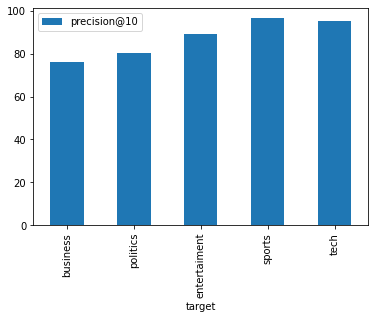

In [87]:
df_p1 = pd.DataFrame.from_dict(p1, orient='index', columns=['precision@10'])

df_p1["target"] =  ["business", "politics", "entertaiment", "sports", "tech"]

d = df_p1.set_index("target")

d.plot.bar()

Podemos ver, que la categoria que mejor se clasifica sigue siendo deportes, mientras que la peor es otra vez negocios. Tampoco vemos que las precisiones mejoren ni empeoren respecto a la clasificación que hemos hecho en el punto 2, con lo cual nos da un poco igual en este caso cual de las dos formas podemos usar. Lo que si podemos decir, es que ambas recuperan los textos y los clasifican con una precisión bastante alta.

## 4) Análisis de errores

Vamos a investigar los resultados para entender mejor dónde están fallando los procesos de recuperación. Sigue los siguientes pasos.


1. Identifica la categoría de noticias donde la precisión media haya mejorado más al incorporar word-embeddings
2. Para dicha categoría, identifica la consulta donde la precisión haya mejorado más al usar word-embeddings
3. Muestra el texto original de la consulta y los términos que aparecen en las dos vectorizaciones tf-idf que usamos (recuerda que usamos diccionarios distintos para las vectorizaciones bolsa de palabras y word-embeddings).
4. Identifica las noticias recuperadas para dicha consulta para las dos aproximaciones y sus categorías (TF-IDF puro y con word-embeddings)
5. Muestra la intersección de términos entre la consulta y la primera noticia mal recuperada usando TF-IDF puro.
6. Muestra la intersección de términos entre la consulta y la última noticia bien recuperada usando word-embeddings.
7. A la luz de todo lo anterior, razona sobre por qué crees que el TF-IDF no fue capaz de clasificar bien la noticia y el word-embedding sí.


Puedes usar el código que calcula la intersección de términos que ponemos a continuación

In [92]:
def terms_in_message(feature_names,vector_data,index):
    '''
    Devuelve un conjunto los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    mensaje=vector_data[index,:]>0
    terminos_presentes = ma.array(feature_names, mask = ~(mensaje[0].toarray()))

    return set(terminos_presentes.compressed())

1. Identifica la categoría de noticias donde la precisión media haya mejorado más al incorporar word-embeddings

In [93]:
print(p5)
print(p1) ##Precision media con word-embbedings

{'business': 75.42857142857143, 'entertainment': 80.45454545454545, 'politics': 88.0, 'sport': 97.6470588235294, 'tech': 96.0}
{'business': 76.0, 'entertainment': 80.45454545454545, 'politics': 89.0, 'sport': 96.47058823529412, 'tech': 95.33333333333333}


Podemos observar que con los word-embeddings, mejora la precision para negocios y politica, mientras que empeora para tecnologia y deportes. Las mejoras suponen <= 1% del total de la precisión, con lo cual tampoco podemos decir que la mejora sea muy notable. La categoria de politica es la que ha mejorado más.